Jacob Albus (albus2) Ashish Pabba (apabba2)

**Contribution:** Jacob worked on Part 1 and Part 2. Ashish worked on Part 3

## Part 1

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import pandas as pd
import math

from scipy.interpolate import splev
from scipy.optimize import minimize_scalar
from skmisc.loess import loess

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [4]:
def loess_projection_matrix(x, span):
    n = len(x)
    Y = np.identity(n)

    A = np.zeros((n, n))
    for j in range(n):
        y = Y[:, j]
        model = loess(x, y, span=span)
        model.fit()
        A[:, j] = model.predict(x).values
    
    return A

def projection_matrix_diagonal(x, y, span):
    model = loess(x, y, span=span)
    model.fit()
    return model.outputs.diagonal

def cross_validation(x, y, spans):
    n = len(x)
    loocv_errors = []
    gcv_errors = []
    
    for span in spans:
        S_diag = projection_matrix_diagonal(x, y, span)
        S_avg_trace = np.sum(S_diag) / n
        
        model = loess(x, y, span=span)
        model.fit()
        full_fitted = model.predict(x).values

        loocv_error = np.power((y - full_fitted) / (1 - S_diag), 2)
        loocv_errors.append(np.sum(loocv_error) / n)

        gcv_error = np.power((y - full_fitted) / (1 - S_avg_trace), 2)
        gcv_errors.append(np.sum(gcv_error) / n)

    return loocv_errors, gcv_errors

In [5]:
data = pd.read_csv("data/Coding3_data.csv")
x = data['x'].to_numpy()
y = data['y'].to_numpy()

spans = np.arange(0.2, 0.95, 0.05)

loocv_errors, gcv_errors = cross_validation(x, y, spans)
loocv_span = spans[np.argmin(loocv_errors)]
gcv_span = spans[np.argmin(gcv_errors)]

print("Span chosen via loocv:", '{:.2f}'.format(loocv_span))
print("Span chosen via gcv:", '{:.2f}'.format(gcv_span))

Span chosen via loocv: 0.50
Span chosen via gcv: 0.50


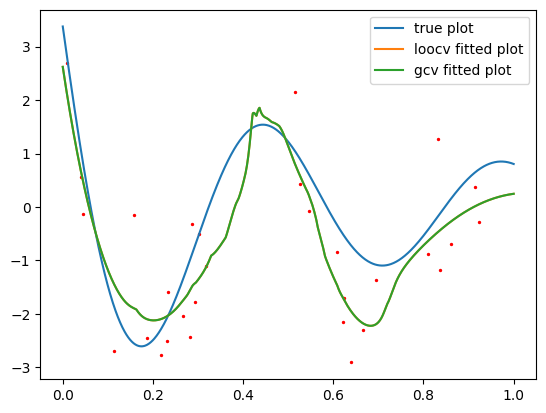

In [6]:
plt.scatter(x, y, color="red", s=2)

fx = np.linspace(0, 1, 1000)
fy = np.sin(12 * (fx + 0.2)) / (fx + 0.2)
plt.plot(fx, fy, label="true plot")

y_hat = loess(x, y, span=loocv_span, surface='direct').predict(fx).values
plt.plot(fx, y_hat, label="loocv fitted plot")

y_hat = loess(x, y, span=0.5, surface='direct').predict(fx).values
plt.plot(fx, y_hat, label="gcv fitted plot")

plt.legend()
plt.show()

## Part 2

#### Task 1

In [17]:
from sklearn.cluster import KMeans

np.random.seed(8067)
data = pd.read_csv("data/Sales_Transactions_Dataset_Weekly.csv").to_numpy()

X = data[:, 1:53].astype(float)
X = X - np.mean(X, axis=-1).reshape(-1, 1)

weeks = np.arange(1, 53)

In [18]:
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)
    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if np.any(outside):
        print("OUTSIDE")
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if np.any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if np.any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if np.any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [19]:
F = ns(np.arange(52), df=9) 
F -= np.mean(F, axis=0) # subtract column mean
print(F.shape)
print(X.shape)
B = (np.linalg.inv(F.T @ F) @ F.T @ X.T).T
print(B.shape)

(52, 9)
(811, 52)
(811, 9)


#### Task 2

In [20]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
kmeans.fit(B)

KMeans(n_clusters=6, n_init='auto', random_state=0)

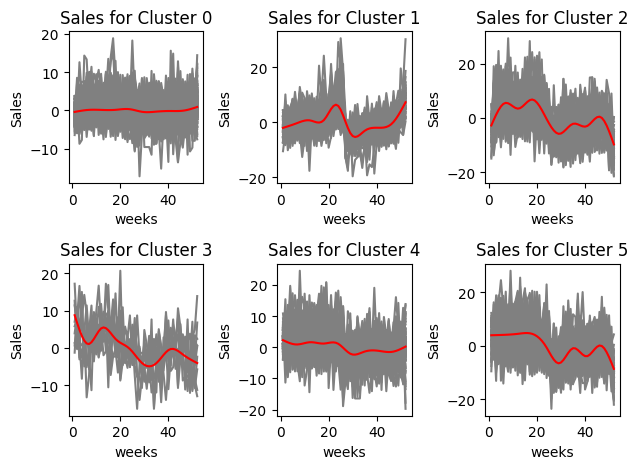

In [21]:
fig = plt.figure()

for label in range(num_clusters):
    plt.subplot(2, 3, label+1)
    
    indices = np.where(kmeans.labels_ == label)
    center = F @ np.mean(B[indices], axis=0)

    selected_X = X[indices]

    plt.plot(weeks, X[0], color="gray")
    for row in selected_X[1:]:
        plt.plot(weeks, row, color="gray")
    plt.plot(weeks, center, color="red")

    plt.xlabel("weeks")
    plt.ylabel("Sales")
    plt.title("Sales for Cluster " + str(label))

fig.tight_layout()

#### Task 3

In [22]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
kmeans.fit(X)

KMeans(n_clusters=6, n_init='auto', random_state=0)

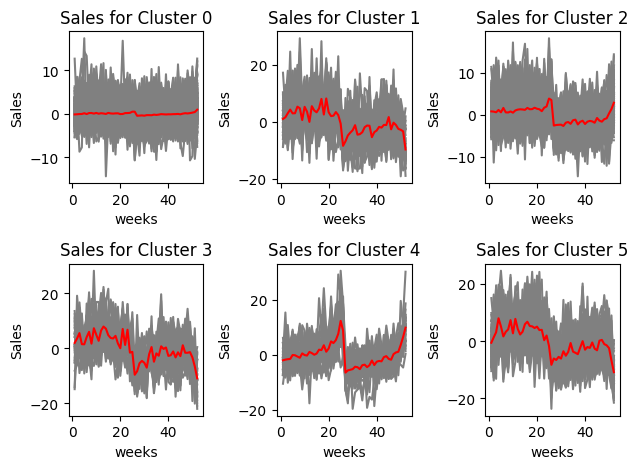

In [23]:
fig = plt.figure()

for label in range(num_clusters):
    plt.subplot(2, 3, label+1)
    
    indices = np.where(kmeans.labels_ == label)
    center = np.mean(X[indices], axis=0)

    selected_X = X[indices]

    plt.plot(weeks, X[0], color="gray")
    for row in selected_X[1:]:
        plt.plot(weeks, row, color="gray")
    plt.plot(weeks, center, color="red")

    plt.xlabel("weeks")
    plt.ylabel("Sales")
    plt.title("Sales for Cluster " + str(label))

fig.tight_layout()

## Part 3

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression as lm
from sklearn.metrics import mean_squared_error

data = np.loadtxt("data/Coding3_dataH.csv", delimiter=",", dtype=float)

scaler = StandardScaler(with_std=False)
data[:, 1:] = scaler.fit_transform(data[:, 1:])
n = len(data)
m = len(data[0])

np.random.seed(8067)
np.random.shuffle(data)
train_size = 0.25
print(data.shape)
X_train = data[:int(n * train_size), 1:]
Y_train = data[:int(n * train_size), 0]
X_test = data[int(n * train_size):, 1:]
Y_test = data[int(n * train_size):, 0]

(506, 241)


In [26]:
from sklearn.decomposition import PCA

def ridgeless(X_train, Y_train, X_test, Y_test):
    pipeline = Pipeline([('pca', PCA())])
    pipeline.fit(X_train)
    X_train = pipeline.transform(X_train)
    
    eigs = np.diag(X_train.T @ X_train)
    eps = 1e-10
    last_valid_index = np.where(eigs > eps)[-1][-1]
    X_train = X_train[:, :last_valid_index]
    
    coefs = Y_train.T @ X_train / np.sum(X_train**2, axis=0)
    b0 = np.mean(Y_train)

    preds = X_train @ coefs.T + b0
    train_error = np.sum((Y_train-preds)**2) / len(X_train)

    X_test = pipeline.transform(X_test)
    X_test = X_test[:, :last_valid_index]
    preds = X_test @ coefs.T + b0
    test_error = np.sum((Y_test-preds)**2) / len(X_test)
    
    return train_error, test_error

In [27]:
T = 30
d_values = [i for i in range(6, 241)]

errors = []

for t in range(T):
    print("Iteration:", t)
    iteration_errors = []

    np.random.shuffle(data)
    train_size = 0.25
    
    for d in d_values:
        X_train = data[:int(n * train_size), 1:d]
        Y_train = data[:int(n * train_size), 0]
        X_test = data[int(n * train_size):, 1:d]
        Y_test = data[int(n * train_size):, 0]
        
        _, test_error = ridgeless(X_train, Y_train, X_test, Y_test)
        iteration_errors.append(np.log(test_error))

    errors.append(iteration_errors)

errors = np.array(errors)
print(errors.shape)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
(30, 235)


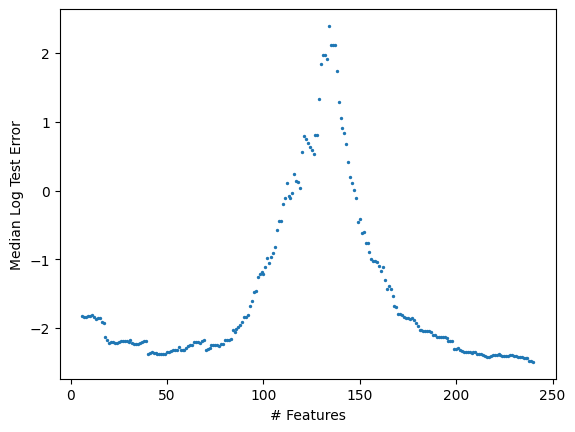

In [28]:
errors_medians = np.median(errors, axis=0)

plt.scatter(d_values, errors_medians, s=2)
plt.xlabel("# Features")
plt.ylabel("Median Log Test Error")
plt.show()